<a href="https://colab.research.google.com/github/Rabbia-Ijaz/TryItOut/blob/main/TailorMod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import copy

from tensorflow.keras.models import load_model
import tensorflow as tf
import sys
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True

import numpy as np
import cv2
from random import randint
import os
!pip install blend_modes
from blend_modes import soft_light
from IPython.display import display, Image


  Created wheel for blend-modes: filename=blend_modes-2.1.0-cp36-none-any.whl size=9548 sha256=4c12c8258b5b2e14412678a7809818c00344333c06b74ca8f5ec0408770e213c
  Stored in directory: /root/.cache/pip/wheels/95/78/96/f8943447b04c319a6e4a7680df50cc47a70cc5a81657b15494
Successfully built blend-modes


In [3]:
def Display(a,title1="test"):
  cv2.imwrite(title1+'.png',a)
  print(title1)
  display(Image(filename=title1+'.png'))

def InputData(shirt1,cropped1,shirt2,cropped2):
  shirt1C=cv2.imread(shirt1,1)
  shirt1G=cv2.imread(shirt1,0)

  shirt2C=cv2.imread(shirt2,1)
  shirt2G=cv2.imread(shirt2,0)

  cropped1C=cv2.imread(cropped1,1)    
  cropped1G=cv2.imread(cropped1,0)
  
  cropped2C=cv2.imread(cropped2,1)
  cropped2G=cv2.imread(cropped2,0)
  
  #dim=(shirt2C.shape[1],shirt2C.shape[0])
  Display(cropped1C)
  Display(cropped2C)
  Display(shirt1C)
  Display(shirt2C)
  return shirt1C,shirt1G,cropped1C,cropped1G,shirt2C,shirt2G,cropped2C,cropped2G

def Edge(img):
  temp=cv2.Canny(img,100,200)
  Display(temp,"Edge")
  return temp

def Thresh(croppedG):
  temp = cv2.GaussianBlur(croppedG,(5,5),0)
  thresh = cv2.threshold(temp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  #thresh = cv2.bitwise_not(thresh)
  Display(thresh)
  return thresh

def Map(shirt,cropped):
  i=0
  point=0
  flag=False
  while (flag==False or i<shirt.shape[0]):
    if (flag==True or (shirt[0][i][0]==0 and shirt[0][i][1]==0 and shirt[0][i][2]==0)):
      flag=True
      point=i
    i=i+1

  for j in range(0,cropped.shape[0]):
    i=point
    for k in range(0,cropped.shape[1]):
      shirt[j][i]=[255,0,0]
      i=i+1

  
  Display(shirt)






radius : 100.60318086422517
degreee : 3.0374535686783983
source connect: 44
44
27
33
11
test


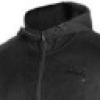

test


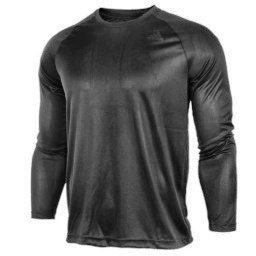

test


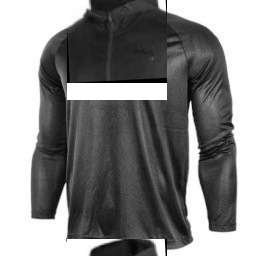

(64, 64)
(100, 100)


In [4]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated


source = cv2.imread(r"/content/drive/MyDrive/Colab Notebooks/collar.jpg", 0)
target = cv2.imread(r"/content/drive/MyDrive/Colab Notebooks/shirt.jpg", 0)

targetLines = cv2.Canny(target, 100, 200)

sourceDim = source.shape[0:1]
targetDim = target.shape[0:1]

targBoxStart =(67, 0)
targBoxEnd = (167, 100)
targBoxDim = ((targBoxEnd[0]-targBoxStart[0]), (targBoxEnd[1]-targBoxStart[1]))

sourceResized = cv2.resize(source, targBoxDim, interpolation=cv2.INTER_AREA)
sourceLines = cv2.Canny(sourceResized, 100, 200)

result = copy.deepcopy(target)

sourceConnect1=0
sourceConnect2=0
targetConnect1=0
targetConnect2=0
check=[0,0,0,0]
for i in range (targBoxDim[0]):
    if (sourceLines[i][0] == 255 and check[0]==0):
        sourceConnect1=i
        check[0]=1
    if (targetLines[i][targBoxStart[0]] == 255 and check[1]==0):
        targetConnect1=i
        check[1]=1
    if (sourceLines[i][targBoxDim[0]-1] == 255 and check[2]==0):
        sourceConnect2=i
        check[2]=1
    if (targetLines[i][targBoxStart[0] + targBoxDim[0]-1] == 255 and check[3]==0):
        targetConnect2=i
        check[3]=1


radius = np.sqrt((targBoxDim[1])**2 + (sourceConnect2-sourceConnect1)**2)
print ("radius : " + str(radius))
degree = (180/np.pi * ((targetConnect1-targetConnect2)/radius))/3
print ("degreee : " + str(degree))

for x in range(targBoxStart[0], targBoxEnd[0]):
    for y in range(targBoxStart[1], targBoxEnd[1]):
        result[y,x]=255

sourceRotated = rotate(sourceResized, degree, (0, sourceConnect1))
print ("source connect: " + str(sourceConnect1))
for x in range(targBoxStart[0], targBoxEnd[0]):
    for y in range(targBoxStart[1], targBoxEnd[1]):
        result[y + (targetConnect1 - sourceConnect1), x] = sourceRotated[y - targBoxStart[1], x - targBoxStart[0]]

print(sourceConnect1)
print(targetConnect1)

print(sourceConnect2)
print(targetConnect2)

Display(sourceResized)
Display(target)

Display(result)
print (source.shape)
print(sourceResized.shape)


test


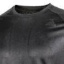

test


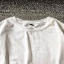

test


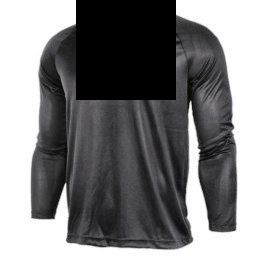

test


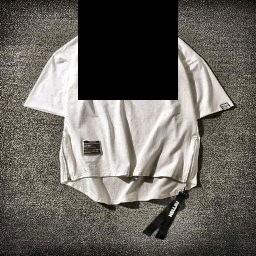

(256, 256, 3)
(256, 256, 3)
test


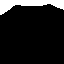

In [6]:
shirt1C,shirt1G,cropped1C,cropped1G,shirt2C,shirt2G,cropped2C,cropped2G=InputData("/content/drive/My Drive/Colab Notebooks/collar1.jpg","/content/drive/My Drive/Colab Notebooks/croppedCollar1.jpg","/content/drive/My Drive/Colab Notebooks/collar2.jpg","/content/drive/My Drive/Colab Notebooks/croppedCollar2.jpg")

print(shirt1C.shape)
print(shirt2C.shape)

thresh=Thresh(cropped1G)
#Map(shirt1C,cropped1C)

In [ ]:
#f = sys.argv[1]
saved = load_model("/content/drive/My Drive/Colab Notebooks/save_ckp_frozen.h5")

In [ ]:
class fashion_tools(object):
    def __init__(self,imageid,model,version=1.1):
        self.imageid = imageid
        self.model   = model
        self.version = version
        
    def get_dress(self,stack=False):
        """limited to top wear and full body dresses (wild and studio working)"""
        """takes input rgb----> return PNG"""
        name =  self.imageid
        file = cv2.imread(name)
        file = tf.image.resize_with_pad(file,target_height=512,target_width=512)
        rgb  = file.numpy()
        file = np.expand_dims(file,axis=0)/ 255.
        seq = self.model.predict(file)
        seq = seq[3][0,:,:,0]
        seq = np.expand_dims(seq,axis=-1)
        c1x = rgb*seq
        c2x = rgb*(1-seq)
        cfx = c1x+c2x
        dummy = np.ones((rgb.shape[0],rgb.shape[1],1))
        rgbx = np.concatenate((rgb,dummy*255),axis=-1)
        rgbs = np.concatenate((cfx,seq*255.),axis=-1)
        if stack:
            stacked = np.hstack((rgbx,rgbs))
            #stacked=rgbs
            return stacked
        else:
            return rgbs
    def get_patch(self):
        return None

###running code



In [ ]:
#segmentation

f="/content/drive/My Drive/Colab Notebooks/3.png"
api    = fashion_tools(f,saved)
image_ = api.get_dress(True)
cv2.imwrite("/content/drive/My Drive/Colab Notebooks/out.png",image_)
display(Image(filename="/content/drive/My Drive/Colab Notebooks/out.png"))

#from PIL import Image
#ima=Image.open("/content/drive/My Drive/Colab Notebooks/out.png")
#ima = ima.convert('RGB')
#ima.save("/content/drive/My Drive/Colab Notebooks/out.jpg")